<a href="https://colab.research.google.com/github/ChrizZhuang/marginalized_graph_kernel_protein/blob/main/Docking_0607.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Mon Jun  7 00:59:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
#!pip install pymatgen==2020.12.31
!pip install pymatgen==2019.11.11
!pip install --pre graphdot
!pip install gdown

In [3]:
%matplotlib inline
import io
import sys
sys.path.append('/usr/local/lib/python3.6/site-packages/')
import os
import urllib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import graphdot
from graphdot import Graph
from graphdot.graph.adjacency import AtomicAdjacency
from graphdot.graph.reorder import rcm
from graphdot.kernel.marginalized import MarginalizedGraphKernel # https://graphdot.readthedocs.io/en/latest/apidoc/graphdot.kernel.marginalized.html
from graphdot.kernel.marginalized.starting_probability import Uniform
from graphdot.model.gaussian_process import (
    GaussianProcessRegressor,
    LowRankApproximateGPR
)
from graphdot.kernel.fix import Normalization
import graphdot.microkernel as uX
import ase.io

/usr/local/lib/python3.7/dist-packages/graphdot/graph/__init__.py:24: UserWarning: Cannot import RDKit, `graph.from_rdkit()` will be unavailable.

  'Cannot import RDKit, `graph.from_rdkit()` will be unavailable.\n'


In [4]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [5]:
#cd gdrive/MyDrive/Google\ Colab/Covid-Data
%cd gdrive/MyDrive/Covid-Data/

/content/gdrive/.shortcut-targets-by-id/1wtzMcocuK8kPsz8K0ktjCZPkv567W6M2/Covid-Data


In [6]:
!pwd

/content/gdrive/.shortcut-targets-by-id/1wtzMcocuK8kPsz8K0ktjCZPkv567W6M2/Covid-Data


In [7]:
files  = ['uncharged_NSP15_6W01_A_3_H.Orderable_zinc_db_enaHLL.2col.csv.1.xz']
dataset = pd.read_pickle(files[0])
#frames = [pd.read_pickle(f) for f in files]
#dataset = pd.concat(frames)

In [8]:
dataset.head()

,energy,smiles,graphs
0,-2.265697,Cc1nc(no1)c2cncnc2[C@@H]3CCCN(C3)C(=O)Cc4ccccc4,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
1,-2.351519,Cc1ccc(cc1)c2nnc(n2N)SCC(=O)Nc3ccccc3OC,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
2,-3.308996,CCOC(=O)Cn1c2ccccc2nc1[C@H]3CC(=O)N(C3)c4ccc(c...,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
3,-3.760179,CC[C@H](C)NC(=O)[C@@H](CC)N(Cc1ccccc1)C(=O)Cc2...,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."
4,-2.895577,Cc1cccc2c1ccn2CCC(=O)N3CCc4cc(c(cc4C3)OC)OC,"Graph(nodes={'!i': [ 0, 1, 2, 3, 4, 5, 6, 7, 8..."


In [9]:
target = 'energy'
N_train = 2500
N_test = 5000

In [10]:
np.random.seed(0)
# select train and test data
train_sel = np.random.choice(len(dataset), N_train, replace=False)
test_sel = np.random.choice(np.setxor1d(np.arange(len(dataset)), train_sel), N_test, replace=False)
train = dataset.iloc[train_sel]
test = dataset.iloc[test_sel]

In [11]:
# import graphdot.microkernel as uX
gpr = GaussianProcessRegressor(
    # kernel is the covariance function of the gaussian process (GP)
    kernel=Normalization( # kernel equals to normalization -> normalizes a kernel using the cosine of angle formula, k_normalized(x,y) = k(x,y)/sqrt(k(x,x)*k(y,y))
        # graphdot.kernel.fix.Normalization(kernel), set kernel as marginalized graph kernel, which is used to calculate the similarity between 2 graphs
        # implement the random walk-based graph similarity kernel as Kashima, H., Tsuda, K., & Inokuchi, A. (2003). Marginalized kernels between labeled graphs. ICML
        MarginalizedGraphKernel( 
            # node_kernel - A kernelet that computes the similarity between individual nodes
            # uX - graphdot.microkernel - microkernels are positive-semidefinite functions between individual nodes and edges of graphs
            node_kernel=uX.Additive( # addition of kernal matrices: sum of k_a(X_a, Y_a) cross for a in features
                # uX.Constant - a kernel that returns a constant value, always mutlipled with other microkernels as an adjustable weight
                #   c, the first input arg. as 0.5, (0.01, 10) the lower and upper bounds of c that is allowed to vary during hyperpara. optimizartion
                # uX.KroneckerDelta - a kronecker delta returns 1 when two features are equal and return h (the first input arg here, which is 0.5 in this case) otherwise
                #   (0.1, 0.9) the lower and upper bounds that h is allowed to vary during hyperpara. optimization
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)), 
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                # uX.SquareExponential 
                # 
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                # uX.Convolution - a convolutional microkernel which averages evaluations of a base microkernel between pairs pf elememts of two variable-length feature sequences
                # uX.KroneckerDelta as the base kernel
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            # edge_kernel - A kernelet that computes the similarity between individual edge
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'), # the strating probability of the random walk on each node
            q=0.05 # the probability for the random walk to stop during each step
        )
    ),
    alpha=1e-4, # value added to the diagonal of the kernel matrix during fitting
    optimizer=True, # default optimizer of L-BFGS-B based on scipy.optimize.minimize
    normalize_y=True, # normalize the y values so taht the means and variance is 0 and 1, repsectively. Will be reversed when predicions are returned
    regularization='+', # alpha (1e-4 in this case) is added to the diagonals of the kernal matrix
)

In [12]:
#gpr.fit(train.graphs, train[target], repeat=3, verbose=True)
# using the molecular graph to predict the energy
gpr.fit(train.graphs, train[target], repeat=1, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|  9.2486e+06|  5.6192e+07|  9.2684e+06|      -19798|  2.2708e+07|   1.3e+02|       1.9|
|  7.0456e+06|   5.459e+07|  7.0642e+06|      -18684|  2.1866e+07|   1.2e+02|       1.8|
|  4.8866e+06|   4.702e+07|  4.9039e+06|      -17315|  2.0461e+07|   1.2e+02|       1.9|
|  4.1676e+06|  4.0965e+07|  4.1844e+06|      -16750|  1.9706e+07|   1.2e+02|       1.9|
|   3.645e+06|  3.5011e+07|  3.6612e+06|      -16274|  1.8948e+07|   1.1e+02|       1.8|
|   3.326e+06|  3.0749e+07|   3.342e+06|      -15946|  1.8322e+07|   1.1e+02|       1.9|
|  3.1778e+06|  2.8881e+07|  3.1936e+06|      -15786|  1.8126e+07|   1.1e+02|       1.9|
|  3.1776e+06|   2.825e+07|  3.1934e+06|      -15766|  1.7637e+07|     1e+02|         2|
|  3.1162e+06|  2.8107e+07|  3.1319e+06|      -15708|  1.7756e+07|   1.1e+02|       1.8|
|  3.1047e+06|  2.791

In [13]:
gpr.kernel.hyperparameters

starting_probability : Uniform
	p : 1.0
stopping_probability : 0.00010000000000000009
node_kernel : Composite
	aromatic : Multiply
		lhs : Constant
			c : 0.02343420535068002
		rhs : KroneckerDelta
			h : 0.18860200789175988
	atomic_number : Multiply
		lhs : Constant
			c : 5.400776905055444
		rhs : KroneckerDelta
			h : 0.10000000000000002
	charge : Multiply
		lhs : Constant
			c : 0.0145590563621646
		rhs : SquareExponential
			length_scale : 1.0
	chiral : Multiply
		lhs : Constant
			c : 0.05149063984443944
		rhs : KroneckerDelta
			h : 0.12853164901299938
	hcount : Multiply
		lhs : Constant
			c : 10.000000000000002
		rhs : SquareExponential
			length_scale : 0.07795674396128768
	hybridization : Multiply
		lhs : Constant
			c : 0.02783411902444354
		rhs : KroneckerDelta
			h : 0.17414808329497075
	ring_list : Multiply
		lhs : Constant
			c : 6.550981640628747
		rhs : Convolution
			base : KroneckerDelta
				h : 0.10000000000000002
edge_kernel : Composite
	aromatic : Multiply
		lhs 

In [14]:
mu = gpr.predict(train.graphs)

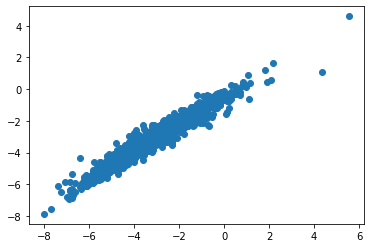

In [15]:
plt.scatter(train[target], mu)
plt.show()

In [16]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.2074369392067814
RMSE: 0.3195501910711287


In [17]:
mu_test = gpr.predict(test.graphs)

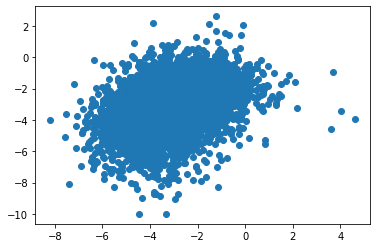

In [18]:
plt.scatter(test[target], mu_test)
plt.show()

In [19]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 1.2461703788060545
RMSE: 1.6040210737240486


In [20]:
gpr2 = GaussianProcessRegressor(
    kernel=Normalization(
        MarginalizedGraphKernel(
            node_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                atomic_number=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                charge=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                chiral=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                hcount=uX.Constant(0.5, (0.01, 10.0)) * uX.SquareExponential(1.0),
                hybridization=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                ring_list=uX.Constant(0.5, (0.01, 100.0)) * uX.Convolution(uX.KroneckerDelta(0.5,(0.1, 0.9)))
            ).normalized,
            edge_kernel=uX.Additive(
                aromatic=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                conjugated=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.5,(0.1, 0.9)),
                order=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                ring_stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9)),
                stereo=uX.Constant(0.5, (0.01, 10.0)) * uX.KroneckerDelta(0.8,(0.1, 0.9))
            ).normalized,
            p=Uniform(1.0, p_bounds='fixed'),
            q=0.05
        )
    ),
    alpha=1e-2, #different from gpr in alpha where gpr's alpha is 1e-4
    optimizer=True,
    normalize_y=True,
    regularization='+',
)

In [21]:
#gpr2.fit(train.graphs, train[target], repeat=3, verbose=True)
gpr2.fit(train.graphs, train[target], repeat=1, verbose=True)

|        logP|       dlogP|     y^T.K.y|     log|K| |     Cond(K)|  GPU time|  CPU time|
|------------|------------|------------|------------|------------|----------|----------|
|   1.667e+05|   1.928e+05|  1.7773e+05|      -11034|  2.2742e+05|   1.3e+02|       1.7|
|  1.5585e+05|  2.2171e+05|  1.6671e+05|      -10857|  2.2218e+05|   1.3e+02|       1.7|
|  1.3711e+05|  2.4873e+05|  1.4756e+05|      -10447|  2.0803e+05|   1.2e+02|       1.8|
|  1.3286e+05|  2.3627e+05|   1.432e+05|      -10338|  2.0336e+05|   1.1e+02|       1.7|
|  1.2977e+05|  2.2744e+05|  1.4002e+05|      -10249|  1.9714e+05|   1.1e+02|       1.7|
|  1.3006e+05|  2.1429e+05|  1.4032e+05|      -10258|  2.0119e+05|     1e+02|       1.7|
|  1.2923e+05|  2.2103e+05|  1.3946e+05|      -10238|  1.9906e+05|   1.1e+02|       1.7|
|  1.2888e+05|  2.2097e+05|  1.3911e+05|      -10228|  1.9865e+05|   1.1e+02|       1.7|
|  1.2843e+05|  2.2338e+05|  1.3864e+05|      -10211|  1.9582e+05|   1.1e+02|       1.7|
|  1.2837e+05|  2.224

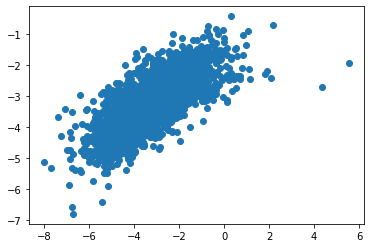

In [22]:
mu = gpr2.predict(train.graphs)
plt.scatter(train[target], mu)
plt.show()

In [23]:
print('Training set')
print('MAE:', np.mean(np.abs(train[target] - mu)))
print('RMSE:', np.std(train[target] - mu))

Training set
MAE: 0.7238389142657052
RMSE: 0.9634943206325994


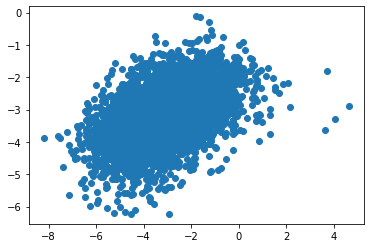

In [24]:
mu_test = gpr2.predict(test.graphs)
plt.scatter(test[target], mu_test)
plt.show()

In [25]:
print('Test set')
print('MAE:', np.mean(np.abs(test[target] - mu_test)))
print('RMSE:', np.std(test[target] - mu_test))

Test set
MAE: 0.9561539409612109
RMSE: 1.2284268143181998
